<a href="https://colab.research.google.com/github/daradanci/MMO_2025/blob/main/notes/LR4_MMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №4  
## Тема: Алгоритмы обучения с подкреплением — Actor-Critic  
### Предмет: Машинное обучение

**Цель работы:**  
Познакомиться с методами обучения с подкреплением на примере реализации алгоритма Actor-Critic в задаче управления динамической системой. Получить практический опыт настройки и обучения агента, способного обучаться через взаимодействие со средой.

## Описание среды Acrobot-v1

`Acrobot-v1` — это система из двух маятников, соединённых друг с другом. Агент управляет только вторым суставом. Цель — заставить конец второго маятника подняться выше заданного уровня, преодолевая силу тяжести.

**Особенности среды:**
- **Состояние (state)** — 6 непрерывных значений:
  - cos(θ1), sin(θ1), cos(θ2), sin(θ2), θ1_dot, θ2_dot (углы и скорости);
- **Действия (actions)** — 3 дискретных значения:
  - 0: крутить назад,
  - 1: ничего не делать,
  - 2: крутить вперёд.
- **Награды (reward)**:
  - каждое действие даёт -1;
  - цель — минимизировать количество шагов до достижения цели (эффективность).

**Завершение эпизода:** когда конец маятника достигает или превышает вертикальный уровень.



In [9]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [15]:
!pip install gymnasium[box2d] torch matplotlib


  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 848.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


In [17]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.model(state)


class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.model(state)


In [18]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

gamma = 0.99
all_rewards = []

for episode in range(500):
    state, _ = env.reset()
    state = torch.FloatTensor(state)
    total_reward = 0

    for t in range(500):
        probs = actor(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        next_state = torch.FloatTensor(next_state)

        td_target = reward + gamma * critic(next_state) * (1 - int(done))
        td_error = td_target - critic(state)

        # Обновление Critic
        critic_loss = td_error.pow(2)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Обновление Actor
        actor_loss = -dist.log_prob(action) * td_error.detach()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        state = next_state
        total_reward += reward
        if done:
            break

    all_rewards.append(total_reward)
    if episode % 50 == 0:
        print(f"Эпизод {episode}, вознаграждение: {total_reward}")


Эпизод 0, вознаграждение: 16.0
Эпизод 50, вознаграждение: 14.0
Эпизод 100, вознаграждение: 63.0
Эпизод 150, вознаграждение: 43.0
Эпизод 200, вознаграждение: 115.0
Эпизод 250, вознаграждение: 210.0
Эпизод 300, вознаграждение: 152.0
Эпизод 350, вознаграждение: 469.0
Эпизод 400, вознаграждение: 149.0
Эпизод 450, вознаграждение: 147.0


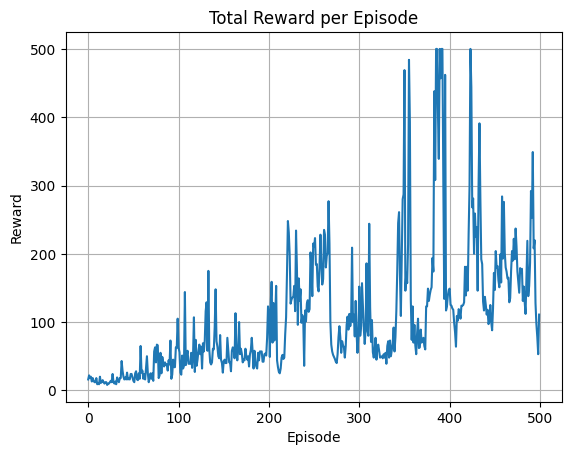

In [19]:
plt.plot(all_rewards)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()
